## The Theta model
The Theta model of Assimakopoulos & Nikolopoulos (2000) is a simple method for forecasting the involves fitting two -lines, forecasting the lines using a Simple Exponential Smoother, and then combining the forecasts from the two lines to produce the final forecast. The model is implemented in steps:

- Test for seasonality

- Deseasonalize if seasonality detected

- Estimate  by fitting a SES model to the data and b0 by OLS.

- Forecast the series

- Reseasonalize if the data was deseasonalized.


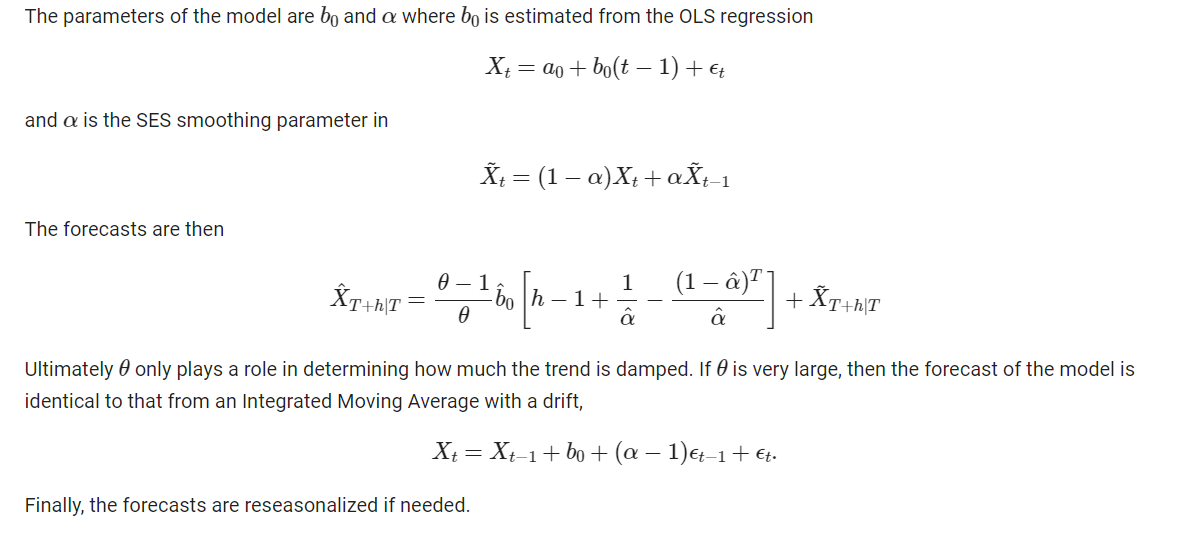
This module is based on:

Assimakopoulos, V., & Nikolopoulos, K. (2000). The theta model: a decomposition approach to forecasting. International journal of forecasting, 16(4), 521-530.

Hyndman, R. J., & Billah, B. (2003). Unmasking the Theta method. International Journal of Forecasting, 19(2), 287-290.

Fioruci, J. A., Pellegrini, T. R., Louzada, F., & Petropoulos, F. (2015). The optimized theta method. arXiv preprint arXiv:1503.03529.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression
import random
import statsmodels.api as sm
import scipy
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from statsmodels.tsa.forecasting.theta import ThetaModel

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
train = pd.read_csv('train.csv', parse_dates=['first_day_of_month'])
test=pd.read_csv('test.csv', parse_dates=['first_day_of_month'])
census=pd.read_csv('census_starter.csv')

In [57]:
train=train.set_index('first_day_of_month')
train.head()

,row_id,cfips,county,state,microbusiness_density,active
first_day_of_month,,,,,,
2019-08-01,1001_2019-08-01,1001,Autauga County,Alabama,3.007682,1249
2019-09-01,1001_2019-09-01,1001,Autauga County,Alabama,2.884870,1198
2019-10-01,1001_2019-10-01,1001,Autauga County,Alabama,3.055843,1269
2019-11-01,1001_2019-11-01,1001,Autauga County,Alabama,2.993233,1243
2019-12-01,1001_2019-12-01,1001,Autauga County,Alabama,2.993233,1243


In [7]:
test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1001_2022-12-01,1001,2022-12-01
2,1001_2023-01-01,1001,2023-01-01
3,1001_2023-02-01,1001,2023-02-01
4,1001_2023-03-01,1001,2023-03-01


In [47]:
test=test.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)
test.head()


,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1001_2022-12-01,1001,2022-12-01
2,1001_2023-01-01,1001,2023-01-01
3,1001_2023-02-01,1001,2023-02-01
4,1001_2023-03-01,1001,2023-03-01


In [9]:
# Unique cfips
unique_cfips= train.cfips.unique()
len(unique_cfips)

3135

# The theta model- visualization

In [159]:
# choosing a dataframe
df=train[train.cfips==1029]

In [187]:
#create a model
#I will use first 31 months data for fitting and last 8 months for forecasting
tm=ThetaModel(df.microbusiness_density[:31],method='additive',period=12)
# fit the model
res=tm.fit()
#forecast for next 8 months
fcast=pd.DataFrame(res.forecast(8,theta=np.inf))
# summarizing the results
print(res.summary())

                                ThetaModel Results                               
Dep. Variable:     microbusiness_density   No. Observations:                   31
Method:                          OLS/SES   Deseasonalized:                   True
Date:                   Fri, 13 Jan 2023   Deseas. Method:               Additive
Time:                           23:19:55   Period:                             12
Sample:                       08-01-2019                                         
                            - 02-01-2022                                         
   Parameter Estimates    
           Parameters     
--------------------------
b0    0.003003362822580664
alpha   0.6076388687736677
--------------------------


In [189]:
# forecast data for plotting
date_range=pd.date_range(start='03-01-22',end='10-01-22',freq='MS')
fcast['first_day_of_month']=date_range
fcast=fcast.set_index('first_day_of_month')
fcast.head()

,forecast
first_day_of_month,
2022-03-01,1.297251
2022-04-01,1.300254
2022-05-01,1.303257
2022-06-01,1.306261
2022-07-01,1.309264


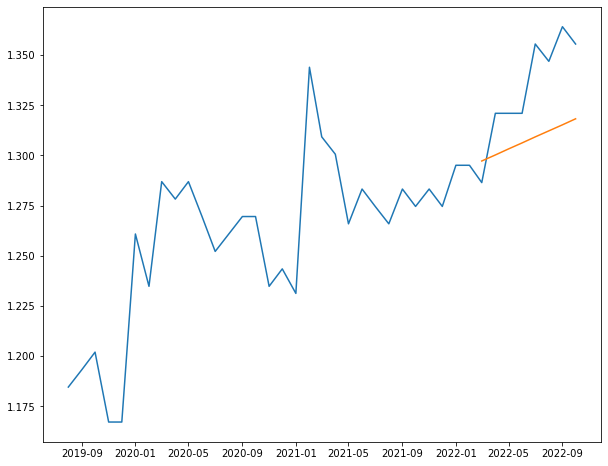

In [193]:
# Plot 
plt.figure(figsize=(10,8))
plt.plot(df.microbusiness_density)
plt.plot(fcast)

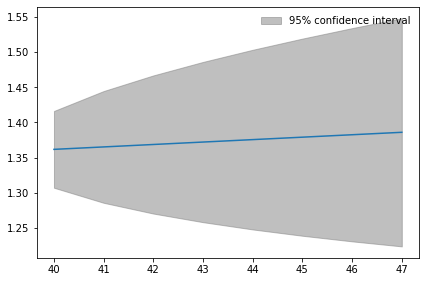

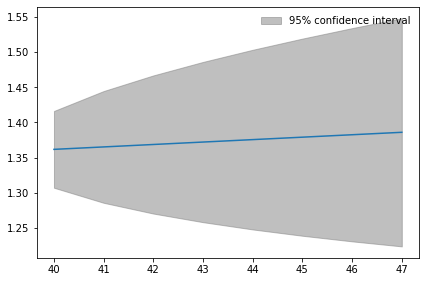

In [170]:
# plotting 95% confidence level
res.plot_predict(8,theta=np.inf)

In [171]:
# printing the trend,ses and seasonal components
res.forecast_components(8)

,trend,ses,seasonal
40,0.005289,1.356317,0.0
41,0.008749,1.356317,0.0
42,0.012210,1.356317,0.0
43,0.015670,1.356317,0.0
44,0.019131,1.356317,0.0
45,0.022591,1.356317,0.0
46,0.026052,1.356317,0.0
47,0.029512,1.356317,0.0


We can easily plot other counties time-series data. Next, I will choose 10 random data counties and plot their actual MBD and the forecasted.

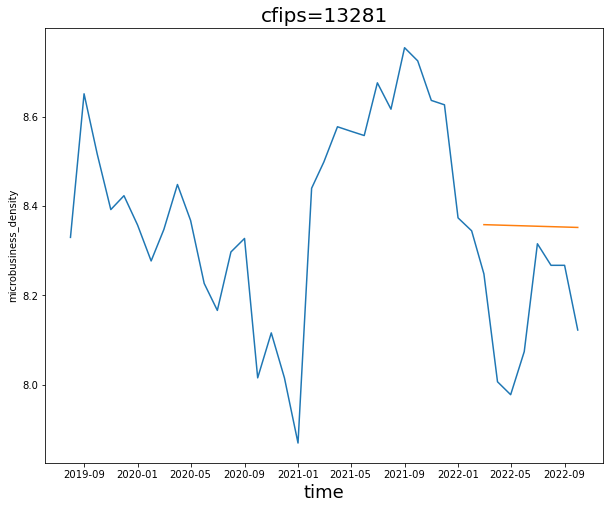

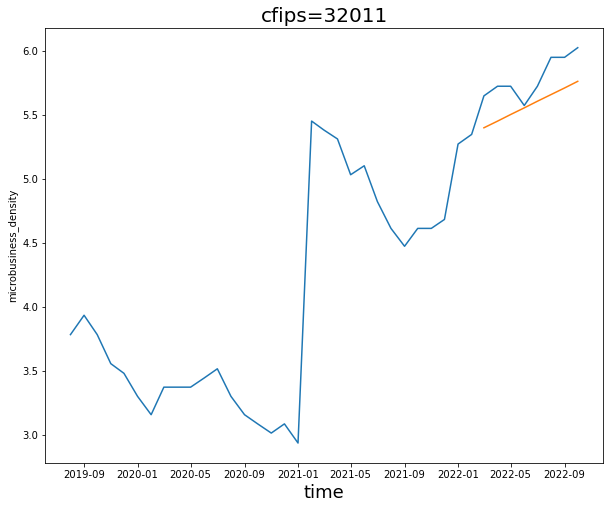

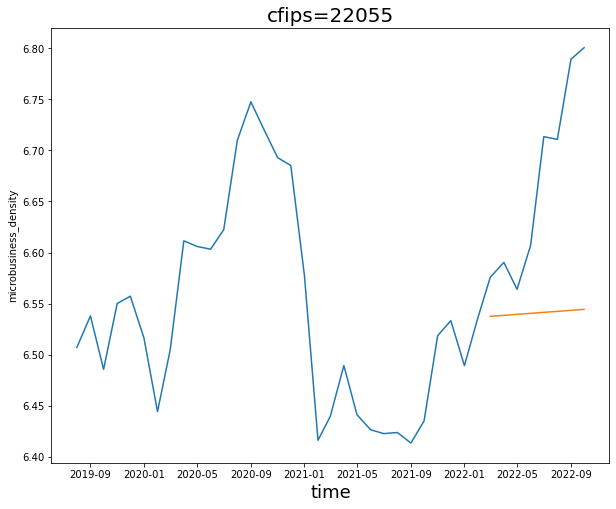

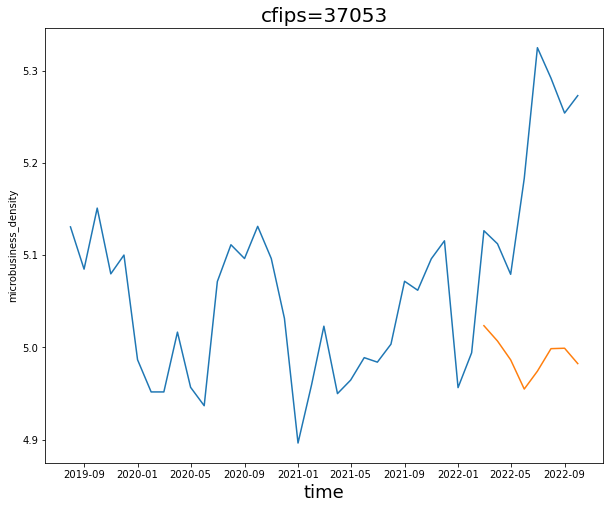

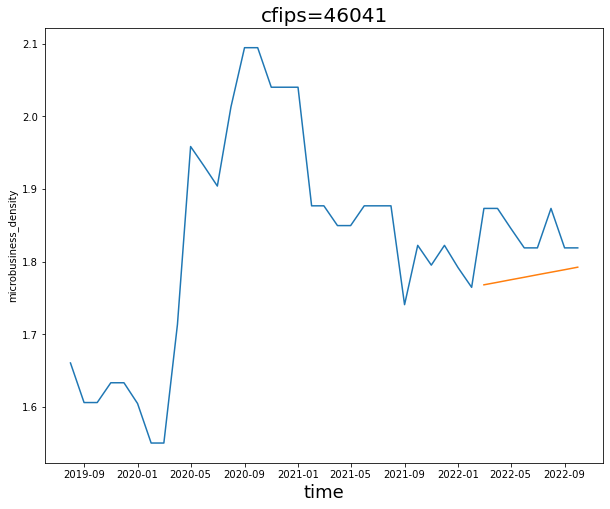

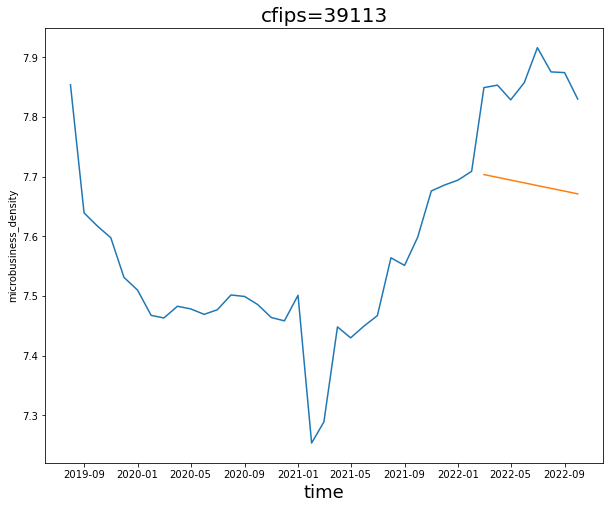

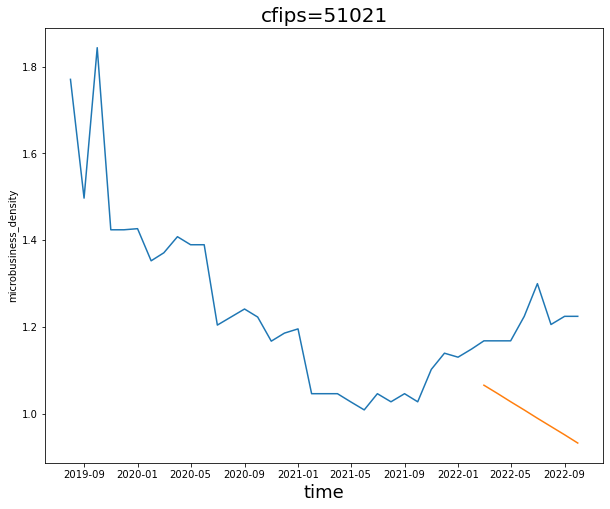

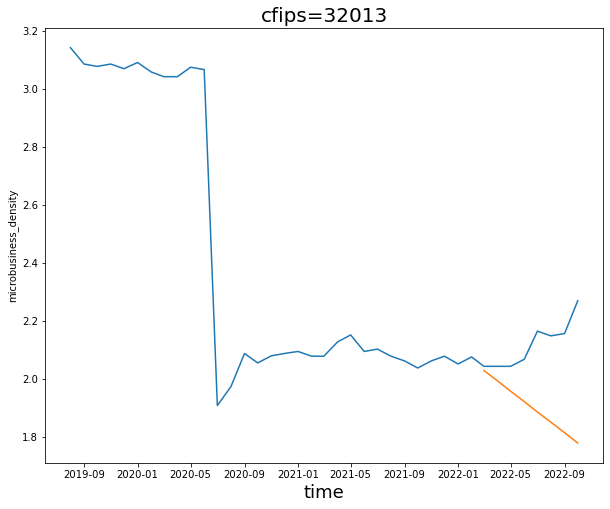

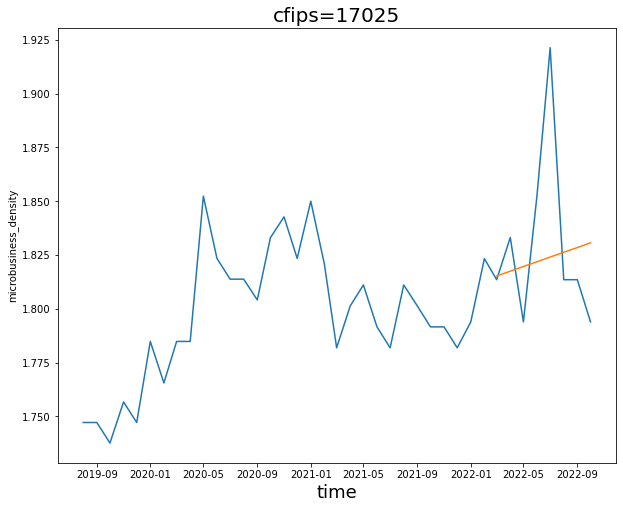

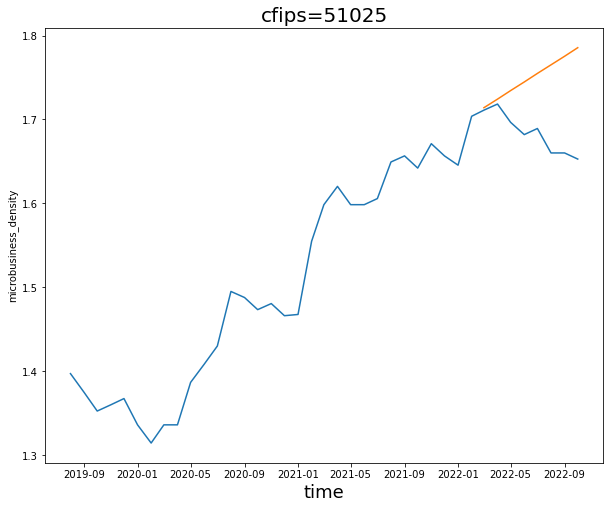

In [205]:
for i in random.choices(unique_cfips,k=10):
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density[:31],method='additive',period=6)
    res=tm.fit(use_mle=True)
    fcast=pd.DataFrame(res.forecast(8,theta=np.inf))
    date_range=pd.date_range(start='03-01-22',end='10-01-22',freq='MS')
    fcast['first_day_of_month']=date_range
    fcast=fcast.set_index('first_day_of_month')
#plotting 
    plt.figure(figsize=(10,8))
    plt.plot(df.microbusiness_density)
    plt.plot(fcast)
    plt.title(f'cfips={i}',fontsize=20)
    plt.xlabel('time',fontsize=18)
    plt.ylabel('microbusiness_density')
    

In [18]:
slope_list=[]
percent_change=[]
for c in unique_cfips:
    df=train.loc[train.cfips==c]
    x=np.arange(1,7).reshape((-1,1))
    y=df.microbusiness_density.values[33:39]
    model=LinearRegression().fit(x,y)
    slope_list.append(model.coef_)
    percent_change.append(6*100*model.coef_/df.microbusiness_density.values[33])

In [59]:
seasonal_cfips=[]
#linear_cfips=[]
last_cfips=[]
for c in unique_cfips:
    df=train.loc[train.cfips==c]
    model=LinearRegression().fit(np.arange(1,7).reshape((-1,1)),df.microbusiness_density.values[33:39])
    slope_list.append(model.coef_)
    percent_change=6*100*model.coef_/df.microbusiness_density.values[33]
    if percent_change>10:
        seasonal_cfips.append(c)
  # elif percent_change>15:
  #   linear_cfips.append(c)
    else:
        last_cfips.append(c)

In [60]:
len(seasonal_cfips),len(last_cfips)

(258, 2877)

In [61]:
y_forecast=[]
cfips_list=[]
for c in seasonal_cfips:
    df=train[train.cfips==c]
    tm=ThetaModel(df.microbusiness_density[12:],method='additive')
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=1)
    y_forecast.append(forecast_)
    cfips_list.append([c]*8)
for cl in last_cfips:
    df=train[train.cfips==cl]
    last=df.microbusiness_density[-1]
    y_fore_last=[last]*8
    y_forecast.append(y_fore_last)
    cfips_list.append([cl]*8)

In [62]:
y_forecast=pd.Series(y_forecast).explode()
cfips_list=pd.Series(cfips_list).explode()
temp=pd.concat([cfips_list,y_forecast],axis=1)
temp.columns=['cfips_list','microbusiness_density']
temp=temp.sort_values('cfips_list')

In [63]:
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.463852
1,1001_2022-12-01,1001,2022-12-01,3.463852
2,1001_2023-01-01,1001,2023-01-01,3.463852
3,1001_2023-02-01,1001,2023-02-01,3.463852
4,1001_2023-03-01,1001,2023-03-01,3.463852


In [65]:
test['microbusiness_density']=temp.microbusiness_density.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.463856
1,1001_2022-12-01,1001,2022-12-01,3.463856
2,1001_2023-01-01,1001,2023-01-01,3.463856
3,1001_2023-02-01,1001,2023-02-01,3.463856
4,1001_2023-03-01,1001,2023-03-01,3.463856


In [66]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_69.csv',index=False)

In [17]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_12.csv',index=False) 
## SMAPE1.771. A dramatic improvements from previous models.

### baseline

In [187]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive')
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=np.inf)
    y_forecast.append(forecast_)

In [188]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.476518
0    3.489722
0    3.502926
0     3.51613
0    3.529334
dtype: object

In [189]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.476518
1,1001_2022-12-01,1001,2022-12-01,3.489722
2,1001_2023-01-01,1001,2023-01-01,3.502926
3,1001_2023-02-01,1001,2023-02-01,3.51613
4,1001_2023-03-01,1001,2023-03-01,3.529334


In [190]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_2.csv',index=False) 
## SMAPE1.5784. A dramatic improvements from previous models.

#### theta=3

In [200]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive')
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=3)
    y_forecast.append(forecast_)

In [201]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.471807
0    3.480609
0    3.489412
0    3.498215
0    3.507018
dtype: object

In [202]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.471807
1,1001_2022-12-01,1001,2022-12-01,3.480609
2,1001_2023-01-01,1001,2023-01-01,3.489412
3,1001_2023-02-01,1001,2023-02-01,3.498215
4,1001_2023-03-01,1001,2023-03-01,3.507018


In [203]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_3.csv',index=False) 
## SMAPE 1.421. A dramatic improvements from previous models.

#### theta=2

In [204]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive')
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=2)
    y_forecast.append(forecast_)

In [205]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.469451
0    3.476053
0    3.482655
0    3.489257
0     3.49586
dtype: object

In [206]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.469451
1,1001_2022-12-01,1001,2022-12-01,3.476053
2,1001_2023-01-01,1001,2023-01-01,3.482655
3,1001_2023-02-01,1001,2023-02-01,3.489257
4,1001_2023-03-01,1001,2023-03-01,3.49586


In [207]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_4.csv',index=False) 
## SMAPE 1.3608. A dramatic improvements from previous models.

#### theta=1.5

In [208]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive')
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=1.5)
    y_forecast.append(forecast_)

In [209]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.467096
0    3.471497
0    3.475899
0      3.4803
0    3.484701
dtype: object

In [210]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.467096
1,1001_2022-12-01,1001,2022-12-01,3.471497
2,1001_2023-01-01,1001,2023-01-01,3.475899
3,1001_2023-02-01,1001,2023-02-01,3.4803
4,1001_2023-03-01,1001,2023-03-01,3.484701


In [211]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_5.csv',index=False) 
## SMAPE 1.3085. A dramatic improvements from previous models.

### Hyperparameter tuning-Theta model

In [112]:
periods=[12]
use_mle=[True,False]
thetas=[1,np.inf]
cfips_list=[]
best_para=[]
for cfips in unique_cfips:
    cfips_list.append(cfips)
    list_=[]
    df=train[train.cfips==cfips].microbusiness_density
    df_train=df[:31]
    df_val=pd.Series(df[31:])
    for period in periods:
        tm=ThetaModel(df_train,method='additive',period=period)
        for i in use_mle:
            res=tm.fit(use_mle=i)#use_mle=True
            for theta in thetas:
                forecast_=pd.Series(res.forecast(8,theta=theta))
                list_.append(((f'period:{period}, use_mle:{i}, theta:{str(theta)}'),MAPE(df_val,forecast_)))
    best_param=sorted(list(enumerate(list_)),key= lambda x:x[1][1])[0][1][0]
    best_para.append(best_param)

In [113]:
best_param=pd.Series(best_para)
cfips_series=pd.Series(cfips_list)

In [114]:
df_temp=pd.concat([best_param,cfips_series],axis=1,ignore_index=True)
df_grouped=df_temp.groupby([0])[1].agg('unique').reset_index()
df_grouped['length']=df_grouped[1].apply(lambda x:len(x))
df_grouped

,0,1,length
0,"period:12, use_mle:False, theta:1","[1001, 1003, 1007, 1009, 1011, 1017, 1021, 102...",1716
1,"period:12, use_mle:True, theta:1","[1005, 1013, 1015, 1019, 1023, 1027, 1029, 103...",1419


In [115]:
temp=df_grouped[0].str.split(',',expand=True).rename(columns={0:'period',1:'use_mle',2:'theta'})

In [116]:
df_merged=pd.concat([df_grouped,
           temp['period'].str.split(':',expand=True),
           temp['use_mle'].str.split(':',expand=True),
           temp['theta'].str.split(':',expand=True)],axis=1,ignore_index=True)
df_merged.head()

,0,1,2,3,4,5,6,7,8
0,"period:12, use_mle:False, theta:1","[1001, 1003, 1007, 1009, 1011, 1017, 1021, 102...",1716,period,12,use_mle,False,theta,1
1,"period:12, use_mle:True, theta:1","[1005, 1013, 1015, 1019, 1023, 1027, 1029, 103...",1419,period,12,use_mle,True,theta,1


In [117]:
df_merged=df_merged.drop([0,2,3,5,7],axis=1)
df_merged.columns=['cfips_list','period','use_mle','theta']
df_merged

,cfips_list,period,use_mle,theta
0,"[1001, 1003, 1007, 1009, 1011, 1017, 1021, 102...",12,False,1
1,"[1005, 1013, 1015, 1019, 1023, 1027, 1029, 103...",12,True,1


In [118]:
df_merged.theta[df_merged.theta=='inf']=np.inf
df_merged.head()

,cfips_list,period,use_mle,theta
0,"[1001, 1003, 1007, 1009, 1011, 1017, 1021, 102...",12,False,1
1,"[1005, 1013, 1015, 1019, 1023, 1027, 1029, 103...",12,True,1


In [119]:
df_merged['period']=df_merged['period'].astype('int64')
df_merged['use_mle']=df_merged['use_mle'].astype('bool')
df_merged['theta']=df_merged['theta'].astype('float')

In [130]:
y_forecast=[]
cfips_list=[]
for index,row in df_merged.iterrows():
    for i in row['cfips_list']:
        cfips_list.append([i]*8)
        df=train[train.cfips==i]
        tm=ThetaModel(df.microbusiness_density,method='additive',period=12)#,period=row['period']
        res=tm.fit(use_mle=row['use_mle'])#
    #perform rolling prediction and multistep forecast
        forecast_=res.forecast(8,theta=1.1)
        y_forecast.append(forecast_)

In [95]:
y_forecast=[]
cfips_list=[]
for index,row in df_merged.iterrows():
    if index==0:
        for i in row['cfips_list']:
            cfips_list.append([i]*8)
            df=train[train.cfips==i]
            tm=ThetaModel(df.microbusiness_density,method='additive',period=12)#,period=row['period']
            res=tm.fit()#use_mle=row['use_mle']
    #perform rolling prediction and multistep forecast
            forecast_=res.forecast(8,theta=1)
            y_forecast.append(forecast_)
    else:
        for i in row['cfips_list']:
            cfips_list.append([i]*8)
            df=train[train.cfips==i]
            tm=ThetaModel(df.microbusiness_density,method='additive',period=12)
            res=tm.fit()
    #perform rolling prediction and multistep forecast
            forecast_=res.forecast(8,theta=np.inf)
            y_forecast.append(forecast_)

In [131]:
cfips_list=pd.Series(cfips_list).explode()
y_forecast=pd.Series(y_forecast).explode()
y_predict=pd.concat([cfips_list,y_forecast],axis=1,ignore_index=True)
y_predict.columns=['cfips','microbusiness_density']
y_predict.head()

,cfips,microbusiness_density
0,1001,3.463967
0,1001,3.46509
0,1001,3.466213
0,1001,3.467336
0,1001,3.468459


In [132]:
y_predict=y_predict.sort_values('cfips').reset_index()
y_predict=y_predict.drop('index',axis=1)
y_predict.head()

,cfips,microbusiness_density
0,1001,3.463967
1,1001,3.46509
2,1001,3.466213
3,1001,3.467336
4,1001,3.468459


In [133]:
test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1001_2022-12-01,1001,2022-12-01
2,1001_2023-01-01,1001,2023-01-01
3,1001_2023-02-01,1001,2023-02-01
4,1001_2023-03-01,1001,2023-03-01


In [134]:
df=pd.concat([test,y_predict],axis=1,ignore_index=True)
df.head(32)

,0,1,2,3,4
0,1001_2022-11-01,1001,2022-11-01,1001,3.463967
1,1001_2022-12-01,1001,2022-12-01,1001,3.46509
2,1001_2023-01-01,1001,2023-01-01,1001,3.466213
3,1001_2023-02-01,1001,2023-02-01,1001,3.467336
4,1001_2023-03-01,1001,2023-03-01,1001,3.468459
5,1001_2023-04-01,1001,2023-04-01,1001,3.469582
6,1001_2023-05-01,1001,2023-05-01,1001,3.470705
7,1001_2023-06-01,1001,2023-06-01,1001,3.471828
8,1003_2022-11-01,1003,2022-11-01,1003,8.381245
9,1003_2022-12-01,1003,2022-12-01,1003,8.378565


In [135]:
df.columns=['row_id', 'cfips', 'first_day_of_month','cfips_2','microbusiness_density']
df.head()

,row_id,cfips,first_day_of_month,cfips_2,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,1001,3.463967
1,1001_2022-12-01,1001,2022-12-01,1001,3.46509
2,1001_2023-01-01,1001,2023-01-01,1001,3.466213
3,1001_2023-02-01,1001,2023-02-01,1001,3.467336
4,1001_2023-03-01,1001,2023-03-01,1001,3.468459


In [136]:
df.shape

(25080, 5)

In [137]:
sub=df[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_hyper10.csv',index=False) 

In [94]:
y_forecast=[]
#for i in unique_cfips:
df=train[train.cfips==1003]
tm=ThetaModel(df.microbusiness_density,method='additive')
res=tm.fit()
    #perform rolling prediction and multistep forecast
forecast_=res.forecast(8,theta=np.inf)
y_forecast.append(forecast_)
y_forecast

[40    8.383216
 41    8.406632
 42    8.430048
 43    8.453464
 44    8.476880
 45    8.500296
 46    8.523712
 47    8.547128
 Name: forecast, dtype: float64]

Using the hyperparameter tuning didn't result in any improvement in the result. It rather increases the MAPE.
In this steps, I explored

### period=12,theta=1,use_mle=false

In [138]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive',period=12)
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=1.1)
    y_forecast.append(forecast_)

In [139]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0     3.46367
0     3.46487
0     3.46607
0    3.467271
0    3.468471
dtype: object

In [140]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.46367
1,1001_2022-12-01,1001,2022-12-01,3.46487
2,1001_2023-01-01,1001,2023-01-01,3.46607
3,1001_2023-02-01,1001,2023-02-01,3.467271
4,1001_2023-03-01,1001,2023-03-01,3.468471


In [141]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_11.csv',index=False) 
## lB score 1.71.

### period=3, theta=1,use_mle=false

In [163]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive',period=3)
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=1)
    y_forecast.append(forecast_)

In [164]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.440106
0    3.463908
0    3.444323
0    3.440106
0    3.463908
dtype: object

In [165]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.440106
1,1001_2022-12-01,1001,2022-12-01,3.463908
2,1001_2023-01-01,1001,2023-01-01,3.444323
3,1001_2023-02-01,1001,2023-02-01,3.440106
4,1001_2023-03-01,1001,2023-03-01,3.463908


In [166]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_7.csv',index=False) 
## LB 1.46.

### period=3, theta=inf,

In [167]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive',period=3)
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=np.inf)
    y_forecast.append(forecast_)

In [168]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.453612
0    3.490567
0    3.484134
0     3.49307
0    3.530025
dtype: object

In [169]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.453612
1,1001_2022-12-01,1001,2022-12-01,3.490567
2,1001_2023-01-01,1001,2023-01-01,3.484134
3,1001_2023-02-01,1001,2023-02-01,3.49307
4,1001_2023-03-01,1001,2023-03-01,3.530025


In [171]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_8.csv',index=False) 
## LB score 1.71.

###  period=12, theta=1,use_mle=True

In [172]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive',period=12)
    res=tm.fit(use_mle=True)
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=1)
    y_forecast.append(forecast_)

In [173]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.462683
0    3.462683
0    3.462683
0    3.462683
0    3.462683
dtype: object

In [174]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.462683
1,1001_2022-12-01,1001,2022-12-01,3.462683
2,1001_2023-01-01,1001,2023-01-01,3.462683
3,1001_2023-02-01,1001,2023-02-01,3.462683
4,1001_2023-03-01,1001,2023-03-01,3.462683


In [176]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_9.csv',index=False) 
## SMAPE 1.3835.

### period=12,theta=inf,use_mle-false

In [76]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive',period=12)
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=np.inf)
    y_forecast.append(forecast_)

In [77]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.476518
0    3.489722
0    3.502926
0     3.51613
0    3.529334
dtype: object

In [78]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.476518
1,1001_2022-12-01,1001,2022-12-01,3.489722
2,1001_2023-01-01,1001,2023-01-01,3.502926
3,1001_2023-02-01,1001,2023-02-01,3.51613
4,1001_2023-03-01,1001,2023-03-01,3.529334


In [180]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_10.csv',index=False) 
## SMAPE 1.58. A dramatic improvements from previous models.

## Results:
- The best score for the theta results was 1.17. 
 
- Note that, no further manipulation needed to achieve the 1.17. Using other algorithm, We need to select the counties that may be best fit with the model. If the metric was not good for that algorithms, last known microbusiness density was used
for the prediction.
-  
- 